In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, average_precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score, train_test_split

import IPython
os.environ['NUMBA_CACHE_DIR'] = IPython.paths.get_ipython_cache_dir()

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Get the user's home directory (e.g., 'C:\Users\user')
DATA_DIR = r"C:\Users\Administrator\Desktop\mlpc"
metadata_dir = os.path.join(DATA_DIR, 'metadata.csv')
features_dir = os.path.join(DATA_DIR, 'audio_features')
labels_dir = os.path.join(DATA_DIR, 'labels')

#### Load Metadata

In [5]:
# Load Metadata & Training Files
metadata = pd.read_csv(metadata_dir)
train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()

#### Load categories

In [6]:
# Load categories
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

#### Aggregate Labels

In [7]:
# Aggregate Labels
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

### Split Train Data

#### Read Files

In [8]:
# Read files and split train data
import itertools
def read_files(file_names, num_to_read=(len(train_files))):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]:
        if not os.path.exists(os.path.join(features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))
    X_train = np.concatenate(X_train)
    return X_train, Y_train

#### Split data without data leakage

In [9]:
# Split data without data leakage
train_files, test_files = train_test_split(metadata["filename"].unique(), test_size=0.2, random_state=42)
#So final split: 80% train, 20% test

# Print number of train and test files
print(f"{'Number of train files: ':<30}{len(train_files)}")
print(f"{'Number of test files: ':<30}{len(test_files)}")

Number of train files:        6584
Number of test files:         1646


#### Load train & test (subset) data

In [10]:
# High computational effort!!!

In [34]:
# Load train & test data
X_train_raw, Y_train = read_files(train_files, 500)
X_test_raw, Y_test = read_files(test_files, 100)

### Apply Feature Normalization & PCA dimensionality reduction (with 95% explained variance)

#### Feature Tensor Scaler

In [35]:
from sklearn.preprocessing import StandardScaler

# Compute scaling parameters ONLY on training data
scaler = StandardScaler().fit(X_train_raw)

#### Scale & Normalize Feature Tensor

In [36]:
# Scale Train and Test Feature Tensor
X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(94258, 768)
(18775, 768)


#### Dimensionality reduction for Feature Tensor with PCA

In [37]:
from sklearn.decomposition import PCA

# PCA dimensionality reduction with keeping 95% of the variance
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_scaled) # fit and transform train feature tensor
X_test = pca.transform(X_test_scaled)       # transform test feature tensor

# print feature tensor shapes
print("Train shapes:", X_train.shape, len(Y_train))
print("Test shapes:", X_test.shape, len(Y_test))

Train shapes: (94258, 170) 58
Test shapes: (18775, 170) 58


In [38]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    average_precision_score, recall_score, f1_score, roc_auc_score
)

def performance_metrics(y_test, y_test_pred):
    accuracy      = accuracy_score(y_test, y_test_pred)
    precision     = precision_score(y_test, y_test_pred, zero_division=0)
    recall        = recall_score(y_test, y_test_pred)
    f1            = f1_score(y_test, y_test_pred)
    roc_auc       = roc_auc_score(y_test, y_test_pred)
    pr_auc        = average_precision_score(y_test, y_test_pred)
    weighted_acc  = balanced_accuracy_score(y_test, y_test_pred)

    print(f"Accuracy:         {accuracy:.3f}")
    print(f"Weighted Accuracy:{weighted_acc:.3f}")
    print(f"Precision:        {precision:.3f}")
    print(f"Recall:           {recall:.3f}")
    print(f"F1 Score:         {f1:.3f}")
    print(f"ROC AUC:          {roc_auc:.3f}")
    print(f"PR AUC:           {pr_auc:.3f}")
    
    return {
        "accuracy": accuracy,
        "weighted_accuracy": weighted_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }


### Baseline Classifier

In [39]:
# Baseline Classifier
class Baseline_classifier():

    def __init__(self):
        self.majority_class = None
        self.classes_ = None

    def fit(self, x_train, y_train):
        '''x_train is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        y_train is a list of binary labels in the shape Nx1
        '''
        self.majority_class = 1 if sum(y_train) > len(y_train) / 2 else 0
        self.classes_= np.array([0, 1]) # possible binary classes (True / False)

    def predict(self, x):
        '''x is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        The function should return the predicted binary labels as a numpy array of shape Nx1
        '''
        predictions = np.zeros(x.shape[0]) + self.majority_class
        return predictions

#### Split Data 'Wind'

In [40]:
# Split data 'Wind'
wind_x_train, wind_y_train = X_train, np.array(Y_train['Wind'])
wind_x_test, wind_y_test = X_test, np.array(Y_test['Wind'])

#### Train baseline model

In [41]:
# Train baseline model
baseline = Baseline_classifier()
baseline.fit(wind_x_train, wind_y_train)

# Predictions
y_train_pred = baseline.predict(wind_x_train)
y_test_pred = baseline.predict(wind_x_test)

#### Baseline Confusion Matrix

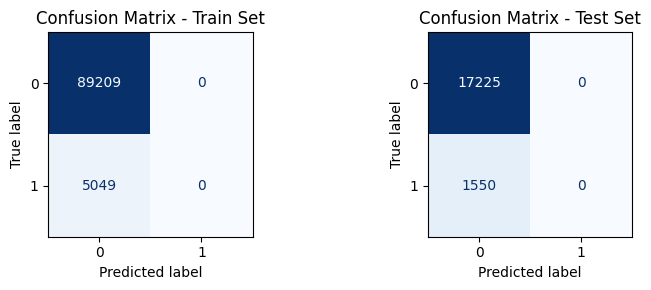

In [42]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Side by side, smaller overall size

# Train confusion matrix
cm_train = confusion_matrix(wind_y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=baseline.classes_)
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set")

# Test confusion matrix
cm_test = confusion_matrix(wind_y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=baseline.classes_)
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()

plt.savefig('Confusion Matrix_Baseline_Classifier_Subset')
plt.show()

#### Baseline Classification Report

In [43]:
from sklearn.metrics import classification_report

# Baseline Classification Report
print("Baseline Classification Report")
print("Training Report:")
print(classification_report(wind_y_train, y_train_pred))
print("\nTest Report:")
print(classification_report(wind_y_test, y_test_pred))

Baseline Classification Report
Training Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     89209
         1.0       0.00      0.00      0.00      5049

    accuracy                           0.95     94258
   macro avg       0.47      0.50      0.49     94258
weighted avg       0.90      0.95      0.92     94258


Test Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     17225
         1.0       0.00      0.00      0.00      1550

    accuracy                           0.92     18775
   macro avg       0.46      0.50      0.48     18775
weighted avg       0.84      0.92      0.88     18775



### kNN Classifier

In [44]:
# High computational effort!!!

In [45]:
# kNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(wind_x_train, wind_y_train)

y_train_pred = knn.predict(wind_x_train)
y_test_pred = knn.predict(wind_x_test)

#### kNN Confusion Matrix

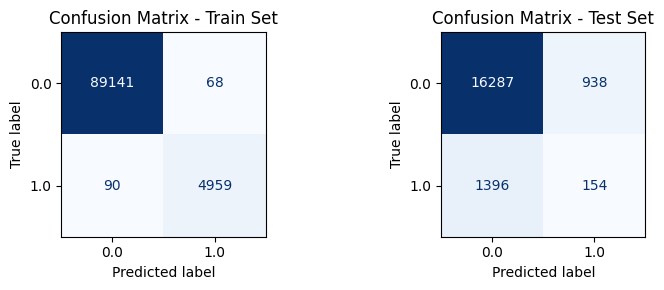

Performance Metrics – k-NN Classifier
Accuracy:         0.876
Weighted Accuracy:0.522
Precision:        0.141
Recall:           0.099
F1 Score:         0.117
ROC AUC:          0.522
PR AUC:           0.088


In [46]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Side by side, smaller overall size

# Train confusion matrix
cm_train = confusion_matrix(wind_y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=knn.classes_)
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set")

# Test confusion matrix
cm_test = confusion_matrix(wind_y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=knn.classes_)
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()

plt.savefig('Confusion Matrix_kNN_Classifier_k10_Subset')
plt.show()

print("Performance Metrics – k-NN Classifier")
knn_perf = performance_metrics(wind_y_test, y_test_pred)

#### kNN Classification Report

In [47]:
from sklearn.metrics import classification_report

# kNN Classification Report
print("kNN Classification Report")
print("Training Report:")
print(classification_report(wind_y_train, y_train_pred))
print("\nTest Report:")
print(classification_report(wind_y_test, y_test_pred))

kNN Classification Report
Training Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     89209
         1.0       0.99      0.98      0.98      5049

    accuracy                           1.00     94258
   macro avg       0.99      0.99      0.99     94258
weighted avg       1.00      1.00      1.00     94258


Test Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93     17225
         1.0       0.14      0.10      0.12      1550

    accuracy                           0.88     18775
   macro avg       0.53      0.52      0.52     18775
weighted avg       0.86      0.88      0.87     18775



#### CUDA availability check

In [48]:
import torch
print("CUDA version:",torch.version.cuda)  # Should show your CUDA version

# CUDA availability check
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

CUDA version: None
Using CPU


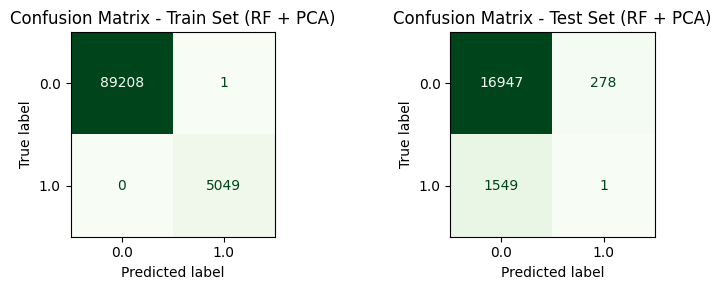

Performance Metrics – Random Forest (PCA Applied)
Accuracy:         0.903
Weighted Accuracy:0.492
Precision:        0.004
Recall:           0.001
F1 Score:         0.001
ROC AUC:          0.492
PR AUC:           0.083


In [49]:
#PCA li RF
scaler = StandardScaler().fit(X_train_raw)
X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 2. Apply PCA to reduce dimensionality while keeping 95% of variance
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

# 3. Train Random Forest on PCA-reduced features
rf_pca = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf_pca.fit(X_train, wind_y_train)

# 4. Make predictions
y_train_pred_pca = rf_pca.predict(X_train)
y_test_pred_pca = rf_pca.predict(X_test)

# 5. Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

disp_train = ConfusionMatrixDisplay(confusion_matrix(wind_y_train, y_train_pred_pca), display_labels=rf_pca.classes_)
disp_train.plot(cmap='Greens', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set (RF + PCA)")

disp_test = ConfusionMatrixDisplay(confusion_matrix(wind_y_test, y_test_pred_pca), display_labels=rf_pca.classes_)
disp_test.plot(cmap='Greens', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set (RF + PCA)")

plt.tight_layout()
plt.show()

# 6. Performance Metrics
print("Performance Metrics – Random Forest (PCA Applied)")
rf_pca_perf = performance_metrics(wind_y_test, y_test_pred_pca)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


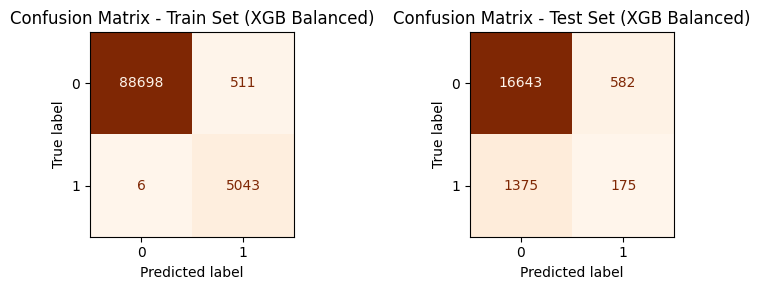

Performance Metrics – XGBoost (Balanced)
Accuracy:         0.896
Weighted Accuracy:0.540
Precision:        0.231
Recall:           0.113
F1 Score:         0.152
ROC AUC:          0.540
PR AUC:           0.099


In [50]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Pozitif sınıf çok az olduğu için scale_pos_weight önemli
# Bu değer genelde: (negatif örnek sayısı) / (pozitif örnek sayısı)
# Aşağıda otomatik hesaplama yapıyoruz:

pos_weight = (wind_y_train == 0).sum() / (wind_y_train == 1).sum()

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=pos_weight,  # ⚠️ DENGELEME!
    random_state=42
)

param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(xgb, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(wind_x_train, wind_y_train)

print("Best Parameters:", grid.best_params_)

best_xgb = grid.best_estimator_

y_train_pred = best_xgb.predict(wind_x_train)
y_test_pred = best_xgb.predict(wind_x_test)

# Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
disp_train = ConfusionMatrixDisplay(confusion_matrix(wind_y_train, y_train_pred), display_labels=best_xgb.classes_)
disp_train.plot(cmap='Oranges', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set (XGB Balanced)")

disp_test = ConfusionMatrixDisplay(confusion_matrix(wind_y_test, y_test_pred), display_labels=best_xgb.classes_)
disp_test.plot(cmap='Oranges', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set (XGB Balanced)")

plt.tight_layout()
plt.show()

print("Performance Metrics – XGBoost (Balanced)")
xgb_perf = performance_metrics(wind_y_test, y_test_pred)

## threshold 0.3

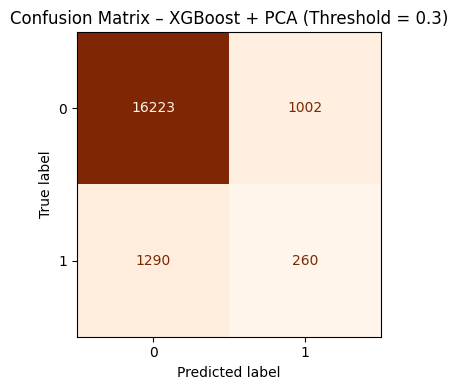

In [51]:
# 1. Normalize features
scaler = StandardScaler().fit(X_train_raw)
X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 2. PCA to preserve 95% variance
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

# 3. Get labels
wind_y_train = np.array(Y_train['Wind'])
wind_y_test = np.array(Y_test['Wind'])

# 4. Handle class imbalance
pos_weight = (wind_y_train == 0).sum() / (wind_y_train == 1).sum()

# 5. Train XGBoost with best-known parameters
best_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=pos_weight,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=100,
    random_state=42
)
best_xgb.fit(X_train, wind_y_train)

# 6. Predict probabilities and apply optimal threshold (0.3)
y_proba = best_xgb.predict_proba(X_test)[:, 1]
y_test_pred = (y_proba >= 0.3).astype(int)

# 7. Confusion matrix
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix(wind_y_test, y_test_pred), display_labels=best_xgb.classes_)
disp.plot(cmap='Oranges', ax=ax, colorbar=False)
ax.set_title("Confusion Matrix – XGBoost + PCA (Threshold = 0.3)")
plt.tight_layout()
plt.show()

